In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager


# read humidity binned values over SST to prepare the composite plot
path_SST_binned = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'
filename = 'H_wind_speed_direction_binned_sst_4.nc'
arthus_data = xr.open_dataset(path_SST_binned+filename)
wspd_data = arthus_data['hspd'].values
sst_arr = arthus_data['sst'].values
height = arthus_data['height'].values


print(arthus_data)



<xarray.Dataset>
Dimensions:  (height: 400, sst: 55)
Coordinates:
  * sst      (sst) float64 26.28 26.31 26.33 26.36 ... 27.56 27.58 27.61 27.63
  * height   (height) float64 0.0 21.21 42.42 ... 8.42e+03 8.442e+03 8.463e+03
Data variables:
    hspd     (sst, height) float64 -0.3676 0.9965 -1.628 -1.732 ... nan nan nan
    hdir     (sst, height) float64 ...
    hspd_n   (sst, height) int64 ...
    hdir_n   (sst, height) int64 ...
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2022-03-04 12:28:37.443114
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  mean values of H wind speed and direction over SST bins
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:        Experimental;Profile;

In [61]:
# rebinning on the same bin size of the rs
# multiplying the variable for the number of values used to calculate the average in the given bin
val_per_n = arthus_data.hspd.values * arthus_data.hspd_n.values

# adding this new variable to the arthus dataset
dims = [ 'sst','height']
coords = {'height':arthus_data.height.values, 'sst':arthus_data.sst.values}
arthus_data['val_per_n'] = xr.DataArray(dims=dims, coords=coords, data=val_per_n,
                 attrs={'long_name':'sst times the number of values '})


# calculate total number of profiles
n_tot = np.sum(arthus_data.hspd_n.values[:,0])


sst_new_grid = binned_sst_rs
dims = ['sst']
coords = {'sst':sst_new_grid}
hspd_new_bins = np.zeros((len(binned_sst_rs), len(arthus_data.height.values)))
hspd_new_bins.fill(np.nan)

# grouping data with respect to the rs sst bins
for ind_arr_rs in range(len(binned_sst_rs)):
    
    # selecting bins in the interval
    if (ind_arr_rs < 4):
        print(ind_arr_rs)
        sst_inf = binned_sst_rs[ind_arr_rs]
        sst_sup = binned_sst_rs[ind_arr_rs+1]
        print(sst_inf, sst_sup)
        arthus_sel = arthus_data.sel(sst=slice(sst_inf,sst_sup))
    else:        
        print(sst_sup)
        arthus_sel = arthus_data.sel(sst=slice(sst_sup, np.nanmax(arthus_data.sst.values)))
    

    arthus_mean = arthus_sel.mean(dim='sst', skipna=True)

    # calculate the number of 
    hspd_new_bins[ind_arr_rs,:] = arthus_mean.val_per_n.values/n_tot

hspd_new_bins_da = xr.DataArray(dims=['sst', 'height'], coords={'sst':sst_new_grid, 'height':arthus_data.height.values}, data=hspd_new_bins,
                 attrs={'long_name':'sst times the number of values '})
variables = {'hspd_new_bins':hspd_new_bins_da}
hspd_dataset_new = xr.Dataset(data_vars = variables,
                              coords = coords)

0
26.45 26.7
1
26.7 26.95
2
26.95 27.2
3
27.2 27.45
27.45


In [53]:
np.where(arthus_data.sst.values > 27.45)[0]

array([47, 48, 49, 50, 51, 52, 53, 54])

['SST=26.45', 'SST=26.7', 'SST=26.95', 'SST=27.2', 'SST=27.45']


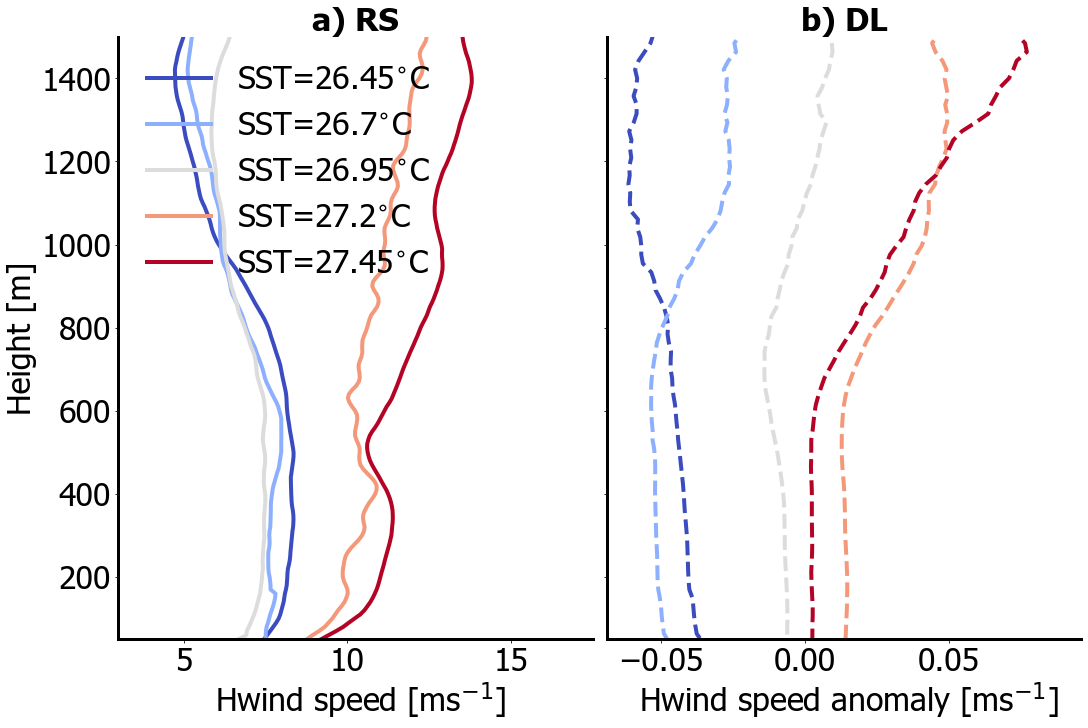

In [65]:
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'


dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']


fig, axs = plt.subplots(1, 2, figsize=(15,10), sharey=True, constrained_layout=True)# 


labels =[]
for ind, el in enumerate(binned_sst_rs):
    labels.append('SST='+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)


#ax = fig.add_subplot(gs[0, 0])

for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[0].plot(wspd_rs[ind_sst_bin,:], height_rs, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin]+'$^{\circ}$C', linewidth=4, rasterized=True)
    
axs[0].legend(frameon=False, fontsize=fontSizeX, loc='upper left')
axs[0].set_xlabel(" Hwind speed [ms$^{-1}$]", fontsize=fontSizeX)
axs[0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0].set_xlim(3,17.5)
axs[0].set_ylim(50.,1500.)

axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(3)
axs[0].spines["left"].set_linewidth(3)
axs[0].set_title('a) RS', fontsize=32, fontweight='black')
for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[1].plot(hspd_dataset_new.hspd_new_bins.values[ind_sst_bin,:], hspd_dataset_new.height.values, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin]+'$^{\circ}$C', linewidth=4, linestyle='--', rasterized=True)
#axs[1].legend(frameon=False, fontsize=fontSizeX, loc='lower left')
axs[1].set_xlabel(" Hwind speed anomaly [ms$^{-1}$]", fontsize=fontSizeX)
#axs[1].set_xlim(3,17.5)
axs[1].set_ylim(50.,1500.)

axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(3)
axs[1].spines["left"].set_linewidth(3)
axs[1].set_title('b) DL', fontsize=32, fontweight='black')
fig.savefig(path_out_plots+'r1_hwind.png')

In [2]:

# calculating uncertainty propagation for hwspd
from myFunctions import f_uncertainty_prop #f_uncertainty_prop(data, sigma_o, n_days, n_sigma, varstring):
''' function to propagate the uncertainty in the measurement and calculate the non-significative bins)
    inputs:
    - data: xarray dataset of data to be plotted
    - sigma_o: initial uncertainty in the data to be provided 
    - n_days: number of days used for the computation of the diurnal cycle
    - n_sigma: number of sigma chosen to check whether the measurement is different than zero.
    - varstring: string identifying the variable name
    outputs: 
    - result : xarray with values smaller than n_sigma*sigma_shf_final masked ''' 
masked_hwspd = f_uncertainty_prop(arthus_data, 1., 8, 3, 'hspd')



In [4]:
# reading radiosonde binned data
radiosonde_data = xr.open_dataset(path_SST_binned+'RS_mean_profiles_binned_sst_2.nc')
wspd_rs = radiosonde_data['H_SPEED'].values
binned_sst_rs = radiosonde_data['sst'].values
height_rs = radiosonde_data['height'].values


# calculate label marks for bins
#sst_bin_label = []
#for ind in range(len(binned_sst_rs)-1):
#    sst_bin_label.append(round((binned_sst_rs[ind]+binned_sst_rs[ind+1])/2,2))

#defining color palette for subsequent plots
colors_binned_sst = plt.cm.coolwarm(np.linspace(0, 1, len(binned_sst_rs)))
# plot multipanel with all profiles


In [17]:
print(np.ediff1d(binned_sst_rs))

[0.25 0.25 0.25 0.25]


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# reading files from Agostino with data from ERA 5 istantaneous and mean on warm/cold 
varname = 'wspd'; units='m_s'; xlabel = 'Wind speed [m/s]'; xmin = 2; xmax = 16


# Space and time info.
lon_warm = -52.75; lat_warm = 8.25 # date_2 = '2020-02-02T00:00:00' on the R/V Atalante trajectory.
lon_cold = -54.4; lat_cold = 6.5 # date_3 = '2020-02-03T12:00:00' on the R/V Atalante trajectory.
dlon = 0.5; dlat = 0.5

date_2 = '2020-02-02T00:00:00'; date_2_str = '2Feb 00UTC'
date_3 = '2020-02-03T12:00:00'; date_3_str = '3Feb 06UTC'

date_start = '2020-02-02'
date_end = '2020-02-03'

# Figure 1
path_file2read = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_agostino/'
file2read = path_file2read+'warm_cold_instants_data_' + varname +'.txt'
ndf = pd.read_csv(file2read)

mean_w2 = ndf[varname+'_w2_'+units]
mean_c2 = ndf[varname+'_c2_'+units]
mean_w3 = ndf[varname+'_w3_'+units]
mean_c3 = ndf[varname+'_c3_'+units]
z_w2 = ndf['height_w2']
z_c2 = ndf['height_c2']
z_w3 = ndf['height_w3']
z_c3 = ndf['height_c3']


# Figure 2

file2read = path_file2read+'warm_cold_time_avg_data_' + varname +'.txt'
ndf = pd.read_csv(file2read)

mean_w = ndf['mean_'+varname+'_w_'+units]
std_w = ndf['std_'+varname+'_w_'+units]
mean_c = ndf['mean_'+varname+'_c_'+units]
std_c = ndf['std_'+varname+'_c_'+units]
z_w = ndf['height_w']
z_c = ndf['height_c']



['SST=26.45', 'SST=26.7', 'SST=26.95', 'SST=27.2', 'SST=27.45']


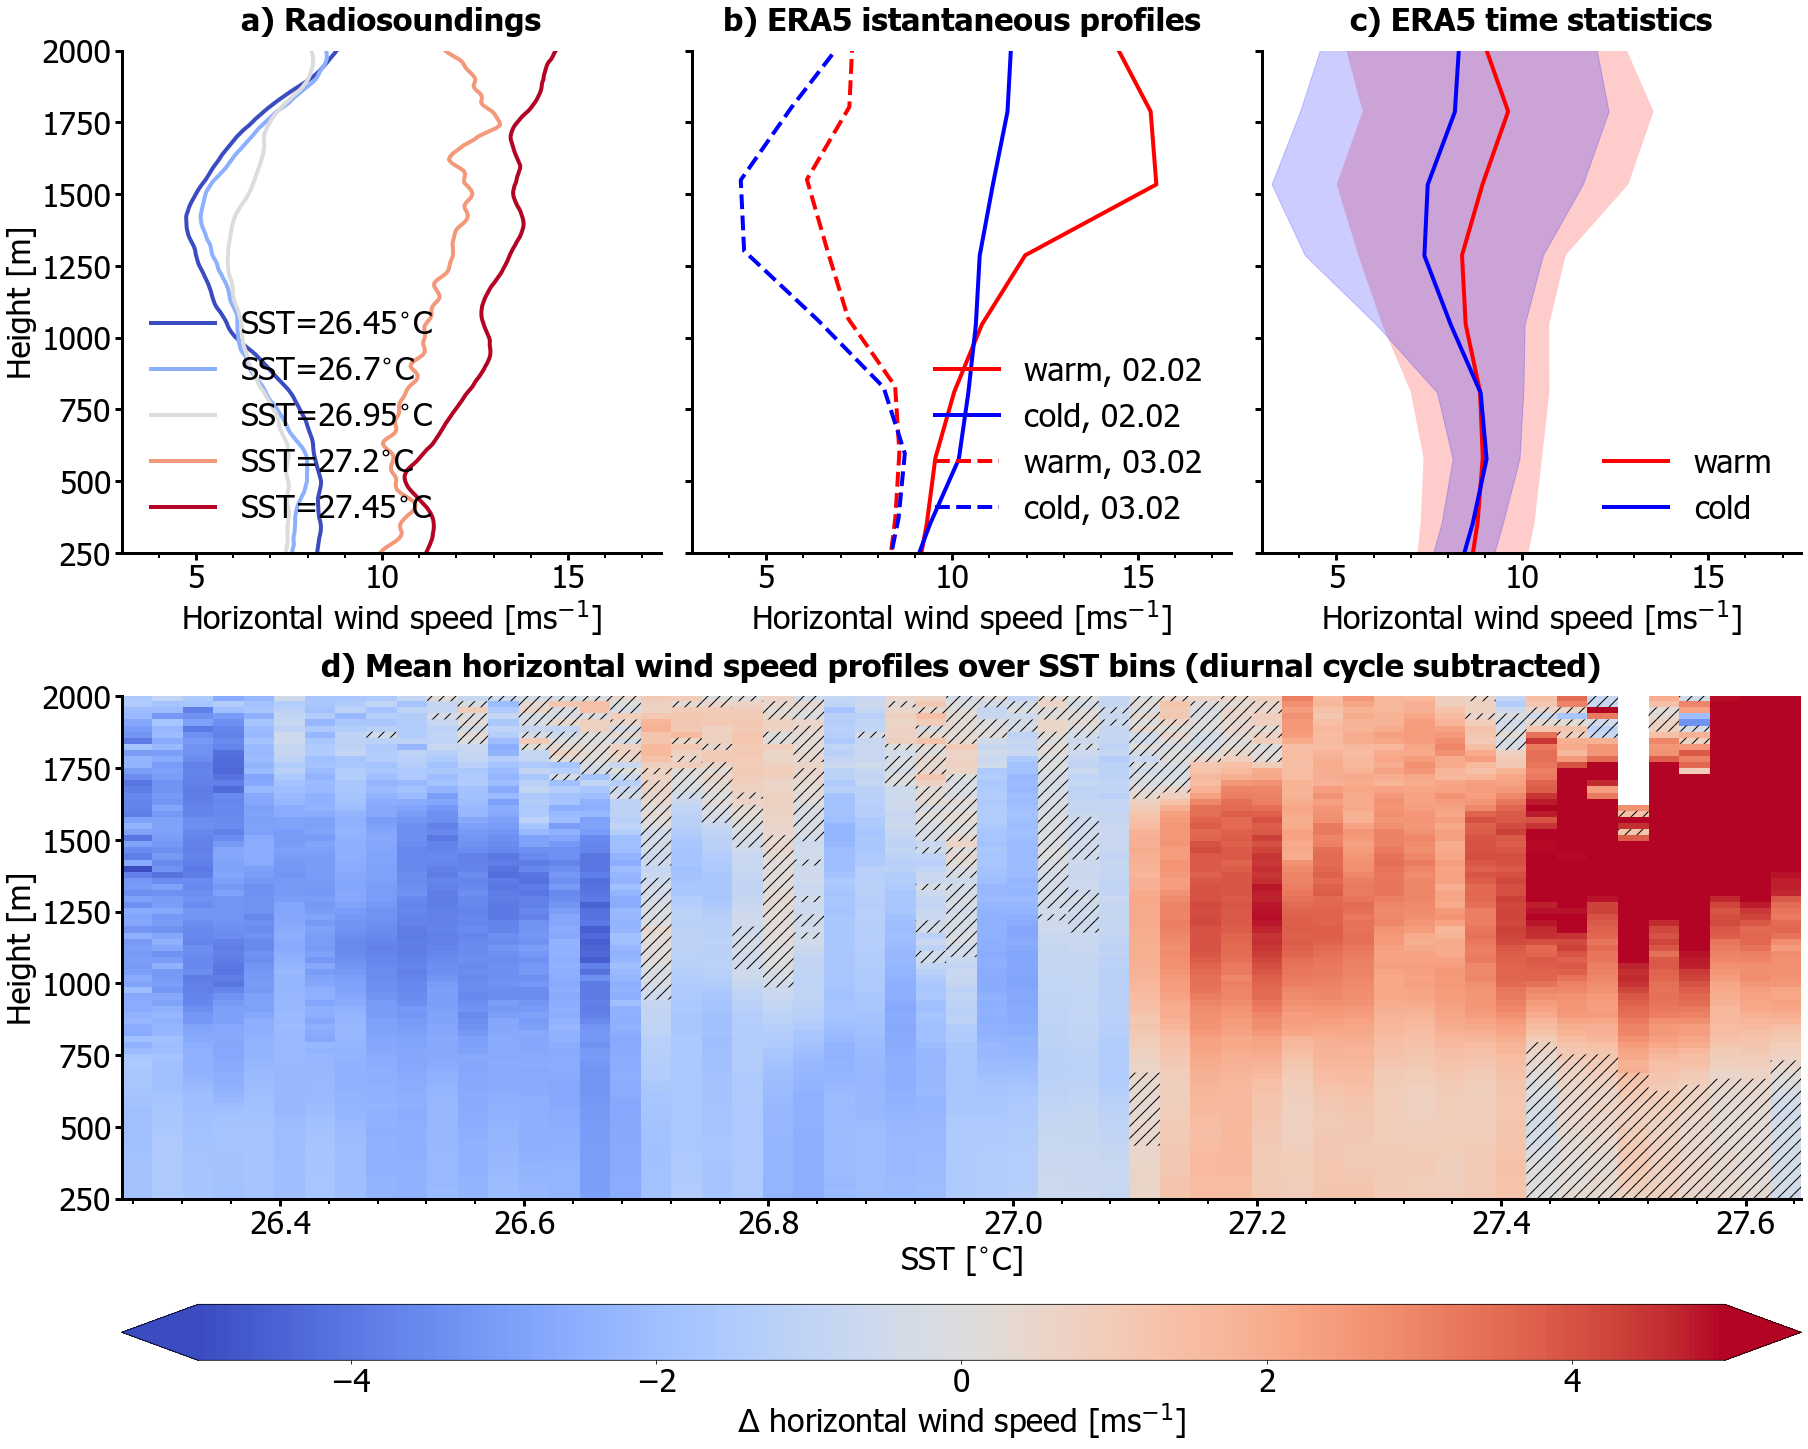

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
rcParams['axes.titlepad'] = 20 
#gs = gridspec.GridSpec(3, 3)

# calculate label marks for bins
#sst_bin_label = []
#for ind in range(len(binned_sst_rs)-1):
#    sst_bin_label.append(round((binned_sst_rs[ind]+binned_sst_rs[ind+1])/2,2))
    


labels =[]
for ind, el in enumerate(binned_sst_rs):
    labels.append('SST='+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'



dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']



fig, axs = plt.subplots(2, 3, figsize=(25,20), sharey=True, constrained_layout=True)# 


#ax = fig.add_subplot(gs[0, 0])

for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[0,0].plot(wspd_rs[ind_sst_bin,:], height_rs, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin]+'$^{\circ}$C', linewidth=4, rasterized=True)
axs[0,0].legend(frameon=False, fontsize=fontSizeX, loc='lower left')
axs[0,0].set_xlabel("Horizontal wind speed [ms$^{-1}$]", fontsize=fontSizeX)
axs[0,0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0,0].set_xlim(3,17.5)
axs[0,0].spines["top"].set_visible(False)
axs[0,0].spines["right"].set_visible(False)
axs[0,0].spines["bottom"].set_linewidth(3)
axs[0,0].spines["left"].set_linewidth(3)
axs[0,0].set_title('a) Radiosoundings', fontsize=32, fontweight='black')

axs[0,0].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,0].tick_params(which='minor', length=5, width=2)
axs[0,0].tick_params(which='major', length=7, width=3)
axs[0,0].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,0].tick_params(axis='both', labelsize=32)
axs[0,0].set_ylim(250.,2000.)    

#-----------------------------

axs[0,1].plot(mean_w2, z_w2, color='red', linewidth=4, rasterized=True, label='warm, 02.02')
axs[0,1].plot(mean_c2, z_c2, color='blue', linewidth=4, rasterized=True, label='cold, 02.02')
axs[0,1].plot(mean_w3,z_w3,'--', color='red', linewidth=4, rasterized=True, label='warm, 03.02')
axs[0,1].plot(mean_c3,z_c3,'--', color='blue', linewidth=4, rasterized=True, label='cold, 03.02')
axs[0,1].set_xlim(3,17.5)
axs[0,1].legend(frameon=False, loc='lower right')

axs[0,1].spines["top"].set_visible(False)
axs[0,1].spines["right"].set_visible(False)
axs[0,1].spines["bottom"].set_linewidth(3)
axs[0,1].spines["left"].set_linewidth(3)
axs[0,1].set_title('b) ERA5 istantaneous profiles', fontsize=32, fontweight='black')
axs[0,1].set_xlabel("Horizontal wind speed [ms$^{-1}$]", fontsize=fontSizeX)

axs[0,1].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,1].tick_params(which='minor', length=5, width=2)
axs[0,1].tick_params(which='major', length=7, width=3)
axs[0,1].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,1].tick_params(axis='both', labelsize=32)
axs[0,1].set_ylim(250.,2000.)

#-----------------------------

axs[0,2].plot(mean_w,z_w,'r', linewidth=4, rasterized=True, label='warm')
axs[0,2].plot(mean_c,z_c,color='blue', linewidth=4, rasterized=True, label='cold')
axs[0,2].fill(np.append(mean_w-std_w, np.flip(mean_w+std_w)),np.append(z_w, np.flip(z_w)),'r',alpha=0.2)
axs[0,2].fill(np.append(mean_c-std_c, np.flip(mean_c+std_c)),np.append(z_c, np.flip(z_c)),color='blue',alpha=0.2)
axs[0,2].set_xlim(3,17.5)
axs[0,2].legend(frameon=False, loc='lower right')
axs[0,2].spines["top"].set_visible(False)
axs[0,2].spines["right"].set_visible(False)
axs[0,2].spines["bottom"].set_linewidth(3)
axs[0,2].spines["left"].set_linewidth(3)
axs[0,2].set_title('c) ERA5 time statistics', fontsize=32, fontweight='black')
axs[0,2].set_xlabel("Horizontal wind speed [ms$^{-1}$]", fontsize=fontSizeX)

axs[0,2].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,2].tick_params(which='minor', length=5, width=2)
axs[0,2].tick_params(which='major', length=7, width=3)
axs[0,2].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,2].tick_params(axis='both', labelsize=32)
axs[0,2].set_ylim(250.,2000.)

#-----------------------------
gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])
axbig.spines["top"].set_visible(False)
axbig.spines["right"].set_visible(False)
axbig.spines["bottom"].set_linewidth(3)
axbig.spines["left"].set_linewidth(3)
axbig.set_title('d) Mean horizontal wind speed profiles over SST bins (diurnal cycle subtracted)', fontsize=32, fontweight='black')

axbig.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axbig.tick_params(which='minor', length=5, width=2)
axbig.tick_params(which='major', length=7, width=3)
axbig.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axbig.tick_params(axis='both', labelsize=32)
axbig.set_ylim(250.,2000.)
mesh = axbig.pcolormesh(sst_arr, height, wspd_data.T, cmap='coolwarm', vmin=-5, vmax=5)
axbig.pcolor(sst_arr, height, masked_hwspd.T, hatch='//', alpha=0.)

cbar = fig.colorbar(mesh, ax=axbig, orientation='horizontal', extend='both', aspect=30)
cbar.set_label(label='$\Delta$ horizontal wind speed [ms$^{-1}$]',  size=fontSizeX)
axbig.set_ylabel('Height [m]', fontsize=fontSizeX)
axbig.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

fig.savefig(path_out_plots+'figure_Hwspd.png', format='png')

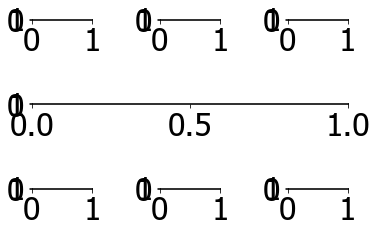

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=3)
gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])
#axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#               xycoords='axes fraction', va='center')

fig.tight_layout()

plt.show()